In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# required for building the CNN
import tensorflow as tf

# required for splitting the data into training and testing sets
from sklearn.model_selection import train_test_split 

%matplotlib inline

Let's start by reading the training and testing data.

In [4]:
train_csv = pd.read_csv('../input/train.csv')
test_csv = pd.read_csv('../input/test.csv')
train_csv.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Storing the pixel and label data into a separate variables, required for our machine learning algorithm.

In [5]:
train_images = train_csv.drop('label', axis=1).values.tolist()
test_images = test_csv.values.tolist()

train_images = [np.array(pixels, dtype='int64') for pixels in train_images]
test_images = [np.array(pixels, dtype='int64') for pixels in test_images]

train_csv['pixels'] = train_images
test_csv['pixels'] = test_images

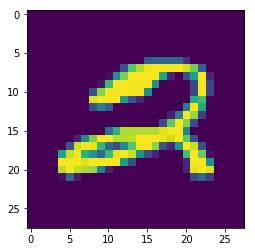

In [27]:
plt.imshow(train_csv.loc[1011]['pixels'].reshape((28, 28)))

Defining wrapper functions for Tensorflow methods.

In [6]:
def init_weights(shape):
    '''
    method to initialize the weights of our NN using normal distribution with mean=0 and std=0.1
    '''
    init_random_dist = tf.truncated_normal(shape, stddev=0.1, seed=0)
    return tf.Variable(init_random_dist)

def init_bias(shape):
    '''
    method to initialize the bias of our NN using constant value=0.1 for all nodes
    '''
    init_bias_vals = tf.constant(0.1,shape=shape)
    return tf.Variable(init_bias_vals)

def conv2d(x,W,strides):
    '''
    wrapper method to perform a 2D convolution
    x - input values tensor [batches,height,width,channels]
    W - filter tensor [height,width,channels in, channels out]
    strides - step vector for the filter window [1,2,2,1] - reduces h and w by 2
    '''
    return tf.nn.conv2d(x, W, strides=strides, padding='SAME')

def max_pool(x, shape, strides):
    '''
    wrapper method to perform 2x2 max pooling 
    ksize - window size vector
    strides - step vector for the pooling window [1,2,2,1] - reduces h and w by 2
    '''
    return tf.nn.max_pool(x, ksize=shape, strides=strides, padding='SAME')

def convolutional_layer(x, shape, strides):
    '''
    method to define a convolutional layer in our NN
    '''
    W = init_weights(shape)
    b = init_bias([shape[3]])
    
    return tf.nn.relu(conv2d(x,W,strides)+b)

def fully_connected_layer(layer,size):
    '''
    method to define a fully connected layer in our NN
    '''
    layer_size = int(layer.get_shape()[1])
    W = init_weights([layer_size, size])
    b = init_bias([size])
    
    return tf.matmul(layer, W) + b

Building the Deep CNN in Tensorflow.

In [28]:
# defining a placeholder for our pixel data [batch_size,height,width]
x = tf.placeholder(tf.float32,shape=[None,28,28,1])

# defining a placeholder for our label data [batch_suze,number of classification classes]
y_true = tf.placeholder(tf.float32,shape=[None,10])

# defining a placeholder storing the holding probability for the drop-out 
hold_prob = tf.placeholder(tf.float32)

# defining the first layer of the ANN
## kernel size: 6x6
## image size input: 28x28x1
## image size output: 28x28x10
layer_1 = convolutional_layer(x, shape=[22,22,1,10], strides=[1,1,1,1])

# defining the second layer of the ANN
## kernel size: 2x2
## image size input: 28x28x10
## image size output: 28x28x14
layer_2 = convolutional_layer(layer_1, shape=[10,20,10,14], strides=[1,1,1,1])

# defining the third layer of the ANN
## kernel size: 4x4
## image size input: 14x14x32
## image size output: 14x14x64
####layer_3 = convolutional_layer(layer_2, shape=[4,4,32,64], strides=[1,1,1,1])

# defining the fourth layer of the ANN
## kernel size: 2x2
## image size input: 14x14x64
## image size output: 7x7x64
###layer_4 = convolutional_layer(layer_3, shape=[2,2,64,64], strides=[1,2,2,1])

# defining the fifth layer of the ANN
## kernel size: 3x3
## image size input: 7x7x64
## image size output: 7x7x128
###layer_5 = convolutional_layer(layer_4, shape=[2,2,64,64], strides=[1,1,1,1])

# reshaping the last layer into [batch_size, height*width*channels]
flattened = tf.reshape(layer_2,[-1,28*28*14])

# defining the sixth layer of the ANN
## neuron count: 128
layer_6 = fully_connected_layer(flattened,512)

# neuron drop-out for the last layer
layer_6_dropout = tf.nn.dropout(layer_6, keep_prob=hold_prob)

# getting the prediction from the fully connected layer
## note: the results will not be in softmax format but it is also not really necessary
## neuron count: 10 (equal to the number of classes we need to classify)
y_pred = fully_connected_layer(layer_6_dropout,10)

# defining a loss function
cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=y_true, logits=y_pred))

# defining an optimizer
optimizer = tf.train.AdamOptimizer(learning_rate=0.001)
train = optimizer.minimize(cross_entropy)

# initializing the global variables
init = tf.global_variables_initializer()

Initializing the batch managers.

In [29]:
from sklearn.utils.extmath import softmax

def transform(pixels):
    return pixels.reshape((28, 28, 1))/255

def one_hot_encode(label, num_classes=10):
    encoded = np.zeros(num_classes)
    encoded[label] = 1
    
    return encoded

class Manager():
    
    def __init__(self, df):
        
        self.i = 0
        
        self.df = df
        
        self.pixels = np.zeros( (len(df['pixels']), 28*28) )
        self.labels_raw = []
        
        self.pixels = [pixels for pixels in self.df['pixels']]
        
        self.num_classes = 10
    
    def next_batch_train(self, batch_size):
        
        self.labels_raw = [label for label in self.df['label']]
        
        x = np.zeros(shape=(batch_size,28,28))
        y = np.zeros(shape=(batch_size,self.num_classes))
        
        x = [transform(pixels) for pixels in self.pixels[self.i:self.i+batch_size]]
        y = [one_hot_encode(label, self.num_classes) for label in self.labels_raw[self.i:self.i+batch_size]]
        
        self.i = (self.i+batch_size) % len(self.pixels)
        
        return x,y
    
    def next_batch_predict(self, batch_size):
        
        x = np.zeros(shape=(batch_size,28,28))
        
        x = [transform(pixels) for pixels in self.pixels[self.i:self.i+batch_size]]
        
        self.i = (self.i+batch_size) % len(self.pixels)
        
        return x
    
    def store_raw_labels(self, raw_labels):
        self.labels_raw.append(softmax(raw_labels))
        
    def transform_data(self):
        self.labels_raw = [item for sublist in self.labels_raw for item in sublist]
        self.labels_raw = np.array(self.labels_raw)
        self.labels = np.argmax(self.labels_raw, axis=1)
        self.confidence = np.amax(self.labels_raw, axis=1) 

In [30]:
trainer = Manager(train_csv)
predictor = Manager(test_csv)

Performing Training and Prediction using Tensorflow.

In [31]:
with tf.Session() as sess:
    
    # initializing the global variables within the session
    sess.run(init)
    
    # defining 20 epochs for training = (25 batches x 1680 images) x 20
    N = 25*50
        
    for batch in range(N):
        
        # getting the current batch of images and labels
        images, labels = trainer.next_batch_train(batch_size = 1680)
        
        # training using the current batch, 
        sess.run(train, feed_dict={x: images, y_true: labels, hold_prob: 0.50})
        
        # on each epoch I will print the accuracy on the current batch and the training progress
        if batch % 25 == 0:
            
            # calculating the accuracy on the current batch
            matches = tf.equal(tf.argmax(y_pred,1),tf.argmax(y_true,1))
            acc = tf.reduce_mean(tf.cast(matches,tf.float32))
            accuracy = sess.run(acc,feed_dict={x: images, y_true: labels, hold_prob: 1.0})

            print('Currently on batch {}, progress {:.2%} ----> Accuracy on the current batch is: {:.2%}'
                .format(batch, batch/N, accuracy))
            
    # once the training is done I will perform prediction on the testing set
    
    N = 7
    
    for batch in range(N):
        
        print('Predicting on batch {}'.format(batch))
        
        images = predictor.next_batch_predict(batch_size = 4000)
        
        prediction_batch = sess.run(y_pred, feed_dict={x: images, hold_prob: 1.0})
        predictor.store_raw_labels(prediction_batch)
        
    predictor.transform_data()

Currently on batch 0, progress 0.00% ----> Accuracy on the current batch is: 20.18%
Currently on batch 25, progress 2.00% ----> Accuracy on the current batch is: 80.18%
Currently on batch 50, progress 4.00% ----> Accuracy on the current batch is: 90.12%
Currently on batch 75, progress 6.00% ----> Accuracy on the current batch is: 93.39%
Currently on batch 100, progress 8.00% ----> Accuracy on the current batch is: 93.93%
Currently on batch 125, progress 10.00% ----> Accuracy on the current batch is: 95.12%
Currently on batch 150, progress 12.00% ----> Accuracy on the current batch is: 95.95%
Currently on batch 175, progress 14.00% ----> Accuracy on the current batch is: 96.25%
Currently on batch 200, progress 16.00% ----> Accuracy on the current batch is: 96.85%
Currently on batch 225, progress 18.00% ----> Accuracy on the current batch is: 97.14%
Currently on batch 250, progress 20.00% ----> Accuracy on the current batch is: 97.62%
Currently on batch 275, progress 22.00% ----> Accurac

In [32]:
submission = pd.DataFrame()

submission['ImageId'] = range(1, 28001, 1)
submission['Label'] = predictor.labels
submission.set_index('ImageId', inplace=True)
submission.to_csv('submission-04.csv')